In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


# NECESSARY IMPORTS

In [2]:
#importing the libraries
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.impute import SimpleImputer

import scipy.sparse as sp
from scipy.sparse import csr_matrix

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

import xgboost as xgb


from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

print("All Necessary Libraries are Successfully Imported")


All Necessary Libraries are Successfully Imported


# LOADING DATASETS

In [3]:
train_df = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
test_df = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
movies_df = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")

# EDA(EXPLORATORY DATA ANALYSIS)

## Analysing types & Shapes

In [4]:
#1.Knowing the Types
print("Type of Train Data:",type(train_df))
print("Type of Test Data:",type(test_df))
print("Type of Movies Data:",type(movies_df))

Type of Train Data: <class 'pandas.core.frame.DataFrame'>
Type of Test Data: <class 'pandas.core.frame.DataFrame'>
Type of Movies Data: <class 'pandas.core.frame.DataFrame'>


In [5]:
#Analysing Shapes
print("Shape of Train Data:",train_df.shape)
print("Shape of Test Data:",test_df.shape)
print("Shape of Movies Data:",movies_df.shape)

Shape of Train Data: (162758, 5)
Shape of Test Data: (55315, 4)
Shape of Movies Data: (143258, 14)


In [6]:
#Datatypes in each data frame
print("TRAIN DATA : DATA TYPES")
print(train_df.dtypes)
print("\nTEST DATA : DATA TYPES")
print(test_df.dtypes)
print("\nMOVIES DATA : DATA TYPES")
print(movies_df.dtypes)

TRAIN DATA : DATA TYPES
movieid               object
reviewerName          object
isFrequentReviewer      bool
reviewText            object
sentiment             object
dtype: object

TEST DATA : DATA TYPES
movieid         object
reviewerName    object
isTopCritic       bool
reviewText      object
dtype: object

MOVIES DATA : DATA TYPES
movieid                  object
title                    object
audienceScore           float64
rating                   object
ratingContents           object
releaseDateTheaters      object
releaseDateStreaming     object
runtimeMinutes          float64
genre                    object
originalLanguage         object
director                 object
boxOffice                object
distributor              object
soundType                object
dtype: object


In [7]:
train_stats = train_df.describe(include='all').T
print("Train Data Statistics:")
print(train_stats)

# Summary statistics for Test Data
test_stats = test_df.describe(include='all').T
print("\nTest Data Statistics:")
print(test_stats)

# Summary statistics for Movies Data
movies_stats = movies_df.describe(include='all').T
print("\nMovies Data Statistics:")
print(movies_stats)

Train Data Statistics:
                     count  unique  \
movieid             162758   16812   
reviewerName        162758    4482   
isFrequentReviewer  162758       2   
reviewText          156311  155071   
sentiment           162758       2   

                                                            top    freq  
movieid             escape_the_terminator_tyler_durden_astonish     708  
reviewerName                                    Sherri Morrison     962  
isFrequentReviewer                                        False  113189  
reviewText                              Parental Content Review      29  
sentiment                                              POSITIVE  108761  

Test Data Statistics:
              count unique                                          top   freq
movieid       55315  16786  escape_the_terminator_tyler_durden_astonish    230
reviewerName  55315   4495                              Sherri Morrison    428
isTopCritic   55315      2                  

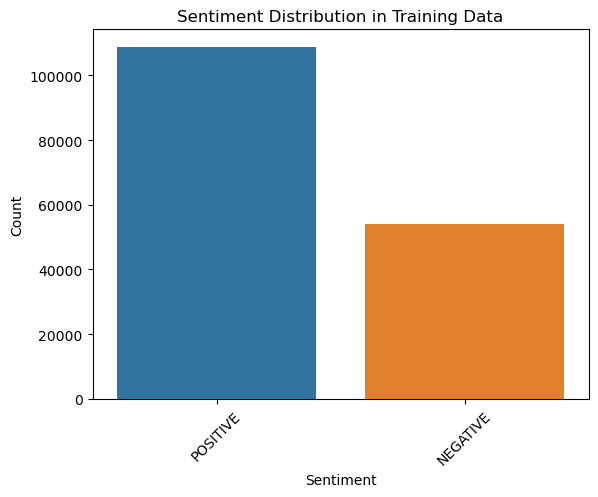

In [8]:
#Visualkizing the Target of Train Data
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='sentiment', data=train_df)
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


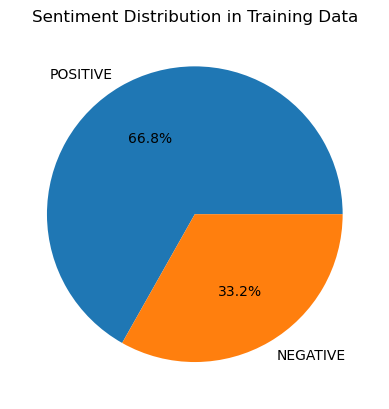

In [9]:
#VISUALIZING THROUGH PIE CHART
plt.pie(train_df['sentiment'].value_counts(), labels=train_df['sentiment'].unique(), autopct='%1.1f%%')
plt.title('Sentiment Distribution in Training Data')
plt.show()

## DETECTING MISSING VALUES

In [10]:
#checking null values
print("Train Data\n")
train_df.isnull().sum()


Train Data



movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

In [11]:
print("\nTest Data\n")
test_df.isnull().sum()


Test Data



movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64

In [12]:
print("\nMOVIES DATA\n")
movies_df.isnull().sum()


MOVIES DATA



movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

## PREPROCESSING ON MOVIES DATASET

In [13]:
#DROPPING UNNECARY COLUMNS
movies = movies_df.drop(columns=['title', 'genre','director','rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes', 'originalLanguage', 'boxOffice', 'distributor',
       'soundType'])

In [14]:
#DROPING DUPLICATES
movies = movies.drop_duplicates()

In [15]:
#CHECKING THE SHAPE
movies.shape

(137838, 2)

### IMPUTING WITH SIMPLE IMPUTER

In [16]:
imputer = SimpleImputer(strategy='mean')
audienceScore =  movies['audienceScore'].values.reshape(-1, 1)
audienceScore_imputed = imputer.fit_transform(audienceScore)
movies['audienceScore'] = audienceScore_imputed #replacing the imputed column to the original one

In [17]:
#Grouping the rows in movies dataframe based on mean of audience score
movie_combined = movies.groupby("movieid").agg({'audienceScore': 'mean'})

In [18]:
movie_combined.shape #checking the shape

(126404, 1)

 ## MERGING MOVIES AND TRAIN & TEST

In [19]:
train_merged = train_df.merge(movie_combined,how='left',on='movieid') #merging train and movies

In [20]:
test_merged = test_df.merge(movie_combined,how='left',on='movieid') #merging test and movies

In [21]:
print("Shape after merging movies and train data:",train_merged.shape)
print("Shape after merging movies and test data:",test_merged.shape)

Shape after merging movies and train data: (162758, 6)
Shape after merging movies and test data: (55315, 5)


In [22]:
#MAPPING POSITIVE : 1 AND NEGATIVE :0
maping={'POSITIVE': 1, 'NEGATIVE': 0}
train_merged['sentiment'] = train_merged['sentiment'].map(maping)

In [23]:
#Storing sentiment label in Y
Y=train_merged['sentiment']

In [24]:
#Dropping Columns in Train data and Test Data
train_merged=train_merged.drop(['sentiment','movieid','reviewerName'],axis=1)
test_merged=test_merged.drop(['movieid','reviewerName'],axis=1)

## CONVERTING CATEGORICAL TO NUMERICAL

In [25]:
train_merged['isFrequentReviewer']=train_merged['isFrequentReviewer'].astype(int) #converting to int datatype
test_merged['isTopCritic']=test_merged['isTopCritic'].astype(int) #converting to int datatype
print(train_merged['isFrequentReviewer'][:5])
print(test_merged['isTopCritic'][:5])

0    0
1    0
2    1
3    0
4    0
Name: isFrequentReviewer, dtype: int64
0    0
1    0
2    0
3    0
4    0
Name: isTopCritic, dtype: int64


In [26]:
##Filling Review Text column  with not available
train_merged["reviewText"].fillna("Not Available",inplace = True)
test_merged["reviewText"].fillna("Not Available",inplace = True)


In [27]:
#renaming isTopCritic to isFrequencyReviewer
test_merged.rename(columns={'isTopCritic': 'isFrequentReviewer'}, inplace=True)

## Preprocessing AudienceScore Column in Train and Test Data

### Using Pipeline

In [28]:
numerical_columns = ['audienceScore']
numerical_pipeline = Pipeline([
    ('ss', StandardScaler())
])
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns)
    ]
)


In [29]:
X_train_transformed = ct.fit_transform(train_merged) #preprocessing the audienceScore of train_df

In [30]:
X_test_transformed = ct.fit_transform(test_merged) #preprocessing the audienceScore of test_Df

In [31]:
train_merged['audienceScore']=X_train_transformed #replacing train_merged['audienceScore'] with preprocessed column

In [32]:
test_merged['audienceScore']=X_test_transformed #replacing test_merged['audienceScore'] with preprocessed column

### Checking all the Shapes

In [33]:
print(train_merged.shape)
print(test_merged.shape)

(162758, 3)
(55315, 3)


## TF-IDF VECTORIZER ON REVIEW TEXT COLUMN

In [34]:
tf_idf = TfidfVectorizer() #Initializing the TF_IDF Vectorizer
tf_idf_train = tf_idf.fit_transform(train_merged['reviewText'])
print("Shape of transformed train matrix is:",tf_idf_train.shape)
tf_idf_test = tf_idf.transform(test_merged['reviewText'])
print("Shape of transformed test matrix is:",tf_idf_test.shape)

Shape of transformed train matrix is: (162758, 65220)
Shape of transformed test matrix is: (55315, 65220)


So from the TF-IDF vectorization we have obtained 65220 columns(features) on review text column

In [35]:
#knowing the type(sparse matrix)
print(type(tf_idf_train))
print(type(tf_idf_test))

<class 'scipy.sparse._csr.csr_matrix'>
<class 'scipy.sparse._csr.csr_matrix'>


Since the review text column is converted to sparse matric , we need to convert other two columns i.e., audienceScore and isFrequentreviewer to sparse

In [36]:
columns_train = train_merged[['isFrequentReviewer','audienceScore']] #getting the columns which are toe be converted to sparse from train
sparse_matrix_train = csr_matrix(columns_train.values) #converting to sparse using csr_matrix
columns_test= test_merged[['isFrequentReviewer','audienceScore']] #getting the columns which are toe be converted to sparse from test
sparse_matrix_test = csr_matrix(columns_test.values) #converting to sparse using csr_matrix

In [37]:
#Analysing the shapes
print(sparse_matrix_train.shape)
print(sparse_matrix_test.shape)

(162758, 2)
(55315, 2)


Now we need to combine both the sparse matrices i.e., (sparse_matrix_train and tf-idf_train ) and (sparse_matrix_test and tf-idf_test)

In [38]:
train_final = sp.hstack([sparse_matrix_train, tf_idf_train]) #joining horizontally usinh hstack
test_final = sp.hstack([sparse_matrix_test, tf_idf_test])

Now our **TRAIN DATA IS READY TO APPLY MODEL**

# LOGISTIC REGRESSION

In [39]:
x_train_log,x_test_log,y_train_log,y_test_log = train_test_split(train_final,Y,test_size=0.2,random_state=42)

model1 = LogisticRegression(max_iter=2500) #Initializing the Model
model1.fit(x_train_log,y_train_log) #Fitting the Model

y_pred_log = model1.predict(x_test_log) #Prediction of targets

accuracy_log = accuracy_score(y_test_log,y_pred_log) #Finding accuracy
print("Accuracy Logistic Regression:",accuracy_log)

Accuracy Logistic Regression: 0.8146964856230032


### Confusion Matrix


In [40]:
confusionmatrix = confusion_matrix(y_test_log, y_pred_log)
print(confusionmatrix)


[[ 6679  4017]
 [ 2015 19841]]


### Plotting Confusion Matrix

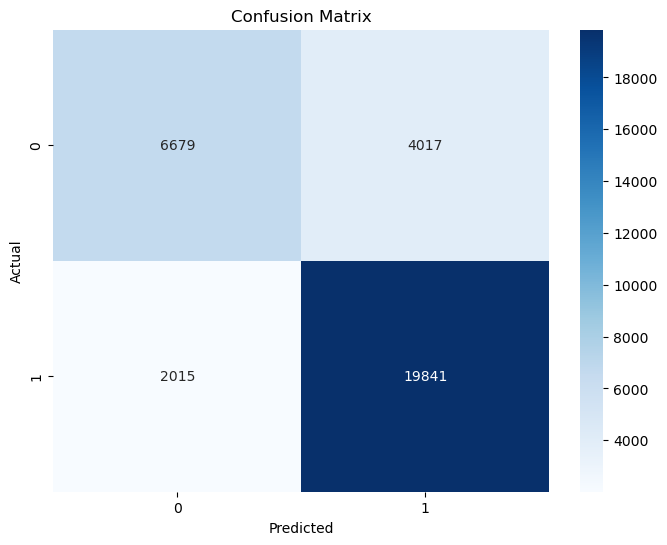

In [41]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusionmatrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [42]:
c_report = classification_report(y_test_log, y_pred_log)
print(c_report.strip())

precision    recall  f1-score   support

           0       0.77      0.62      0.69     10696
           1       0.83      0.91      0.87     21856

    accuracy                           0.81     32552
   macro avg       0.80      0.77      0.78     32552
weighted avg       0.81      0.81      0.81     32552


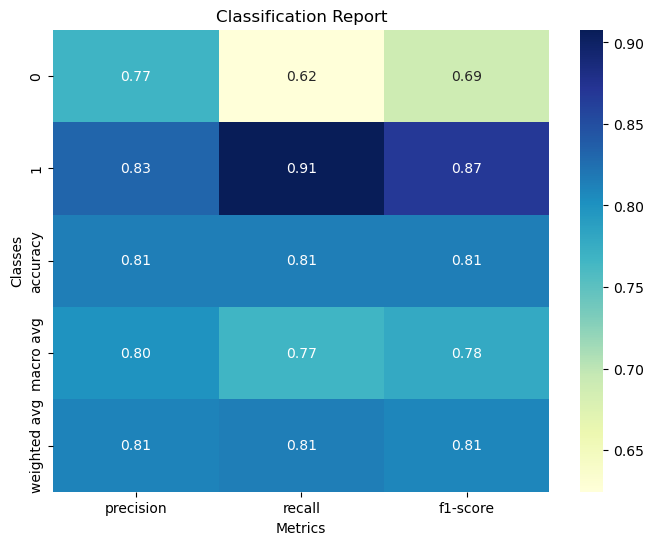

In [43]:
class_report = pd.DataFrame(classification_report(y_test_log, y_pred_log, output_dict=True)).T

# heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(class_report.drop(['support'], axis=1), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()

## HyperParameter Tuning On Logistic Regression

In [44]:
param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter':[2000,3000]
}

grid_search1= GridSearchCV(model1, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search1.fit(x_train_log, y_train_log)
best_model1 = grid_search1.best_estimator_
y_pred_log = best_model1.predict(x_test_log)
accuracy_log = accuracy_score(y_test_log,y_pred_log)
print("Accuracy of LogReg on Hyperparameter Tuning:",accuracy_log)

Accuracy of LogReg on Hyperparameter Tuning: 0.8146964856230032


In [45]:
print("best Parameters:",grid_search1.best_params_)

best Parameters: {'C': 1, 'max_iter': 2000, 'penalty': 'l2'}


# XGBoost  Classifier

In [46]:
X_train, X_test, y_train, y_test = train_test_split(train_final, Y, test_size=0.2, random_state=42)
xgc = xgb.XGBClassifier(
    n_estimators=100,  # Number of  trees
    max_depth=3,       # Maximum tree depth
    learning_rate=0.1, # Learning rate
    random_state=42    # Random seed for reproducibility
)
print("Model is Initialized") # Training/Fitting  the model
xgc.fit(X_train, y_train)
print("Model is Fitted")
y_pred = xgc.predict(X_test) # Getting predictions
print("predicted")
accuracy = accuracy_score(y_test, y_pred) # Evaluate the model
print("Accuracy:", accuracy)

Model is Initialized
Model is Fitted
predicted
Accuracy: 0.7334725976898501


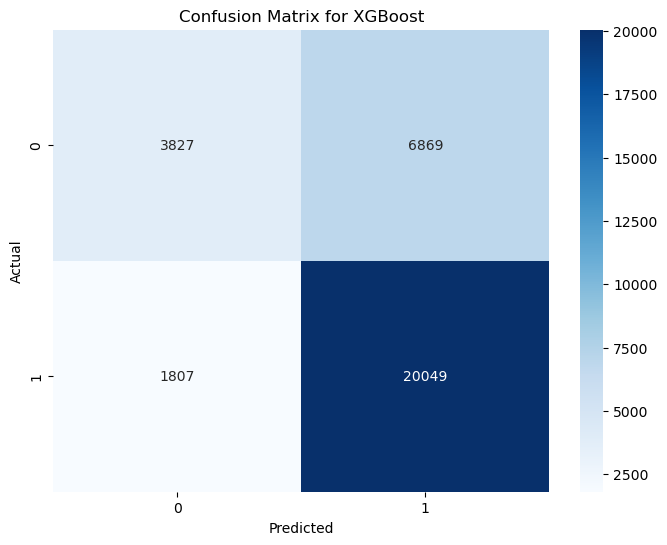

In [47]:
confusionmatrix2 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusionmatrix2, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [48]:
confusionmatrix2

array([[ 3827,  6869],
       [ 1807, 20049]])

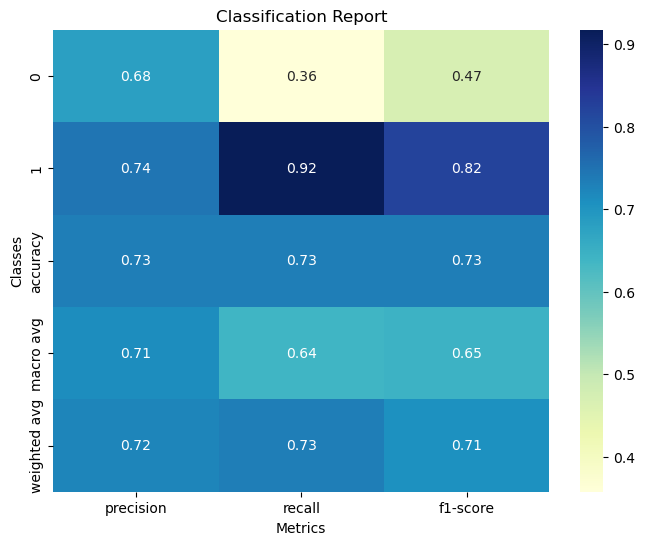

In [49]:
class_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

#heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(class_report.drop(['support'], axis=1), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()

# Adaboost Classifier

In [50]:
X_train, X_test, y_train, y_test = train_test_split(train_final, Y, test_size=0.2, random_state=42)

base_classifier = DecisionTreeClassifier(max_depth=1) #base_classifier :  DecisionTreeClassifier

# CreatING an AdaBoost classifier and passing base_classifier
adaboost_cl = AdaBoostClassifier(base_classifier, n_estimators=50, learning_rate=1.0)

# Train/Fitting the AdaBoost classifier
adaboost_cl.fit(X_train, y_train)

# Making predictions
y_pred = adaboost_cl.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of Adaboost Classifier:", accuracy)


Accuracy of Adaboost Classifier: 0.7333189972966331


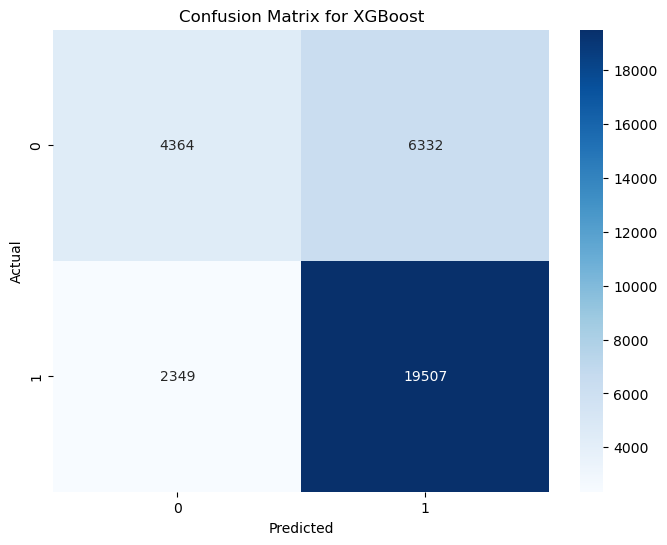

In [51]:
confusionmatrix3 = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusionmatrix3, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix for XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


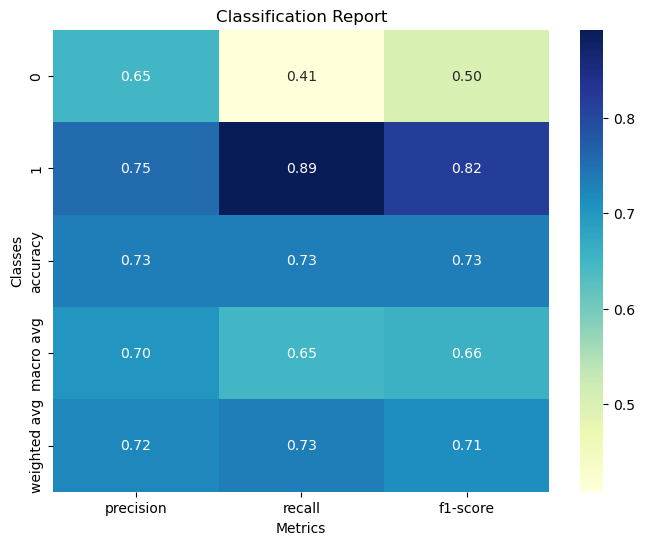

In [52]:
class_report2 = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

#heatmap of the classification report
plt.figure(figsize=(8, 6))
sns.heatmap(class_report2.drop(['support'], axis=1), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()

In [53]:
confusionmatrix3

array([[ 4364,  6332],
       [ 2349, 19507]])

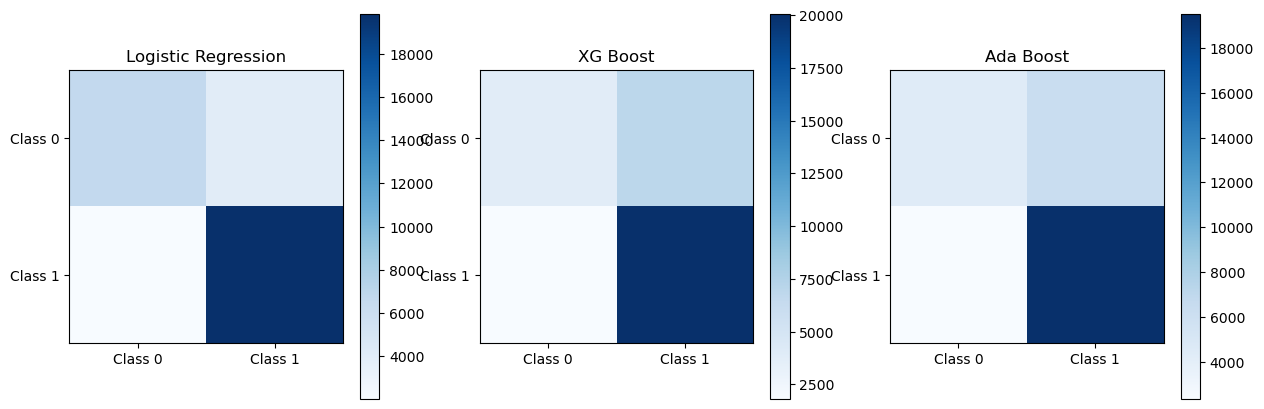

In [61]:
import numpy as np
import matplotlib.pyplot as plt

confusion_matrix_1 = np.array([[6679, 4017], [2015, 19841]])
confusion_matrix_2 = np.array([[3827, 6869], [1807, 20049]])
confusion_matrix_3 = np.array([[4364, 6332], [2349, 19507]])

model_names = ['Logistic Regression', 'XG Boost', 'Ada Boost']
confusion_matrices = [confusion_matrix_1, confusion_matrix_2, confusion_matrix_3]

plt.figure(figsize=(15, 5))

for i, confusion_matrix in enumerate(confusion_matrices):
    plt.subplot(1, 3, i+1)
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(model_names[i])
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Class 0', 'Class 1'])
    plt.yticks(tick_marks, ['Class 0', 'Class 1'])

plt.show()


**Logistic Regression** has relatively balanced numbers of true positives and true negatives, indicating that it is performing reasonably well on both classes. The number of false positives and false negatives is moderate.There fore It is the best model for this problem

# Test predictions

Since Logistic Regression has given us the good accuracy , we are calculating the test_predictions on model1 that is Logistic Regression

In [55]:
test_predictions = model1.predict(test_final) #since model1 has given best accuracy
np.unique(test_predictions)

array([0, 1])

In [56]:
unique_val,count = np.unique(test_predictions,return_counts=True) #we are calculating unique values and their counts
for value, count in zip(unique_val, count):
    print(f"{value}: {count}")


0: 14764
1: 40551


In [57]:
predictions = np.array(test_predictions)
# Convert the ndarray to a string data type
predictions = predictions.astype(str)

# Convert 0 to 'NEGATIVE' and 1 to 'POSITIVE'
predictions[predictions == '0'] = 'NEGATIVE'
predictions[predictions == '1'] = 'POSITIVE'

print(predictions)

['POSITIVE' 'POSITIVE' 'POSITIVE' ... 'POSITIVE' 'POSITIVE' 'NEGATIVE']


In [58]:
submission = pd.DataFrame(columns = ['id','sentiment'])
submission['id'] = [i for i in range(len(predictions))]
submission['sentiment'] = predictions
submission.shape

(55315, 2)

In [59]:
submission.to_csv('submission.csv',index=False)
submission.head()

,id,sentiment
0,0,POSITIVE
1,1,POSITIVE
2,2,POSITIVE
3,3,POSITIVE
4,4,POSITIVE
